In [94]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/cowmonitoringsystem.csv
/kaggle/input/cowmontoring/cowmonitoringsystem.csv


## Import Libraries

In [95]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, f1_score)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


## Load and Clean Data

In [96]:
df = pd.read_csv("/kaggle/input/dataset/cowmonitoringsystem.csv")

# Drop rows that are entirely empty
df = df.dropna(how='all')

# Drop constant columns and any date fields
df = df.drop(columns=[col for col in df.columns if df[col].nunique() == 1])
df = df.drop(columns=['date', 'calvdate'], errors='ignore')

# Drop the old CES column if present
df = df.drop(columns=['CES'], errors='ignore')


## Encode Categorical Features and Target Variable

In [97]:
# Categorical feature encoding
categorical_cols = df.select_dtypes(include='object').columns.tolist()
feature_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    feature_encoders[col] = le

# Encode target
target_col = 'CalvingEaseScore'
te = LabelEncoder()
df[target_col] = te.fit_transform(df[target_col].astype(str))


## Impute Missing Numeric Values

In [98]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())


## Correlation Matrix Plot

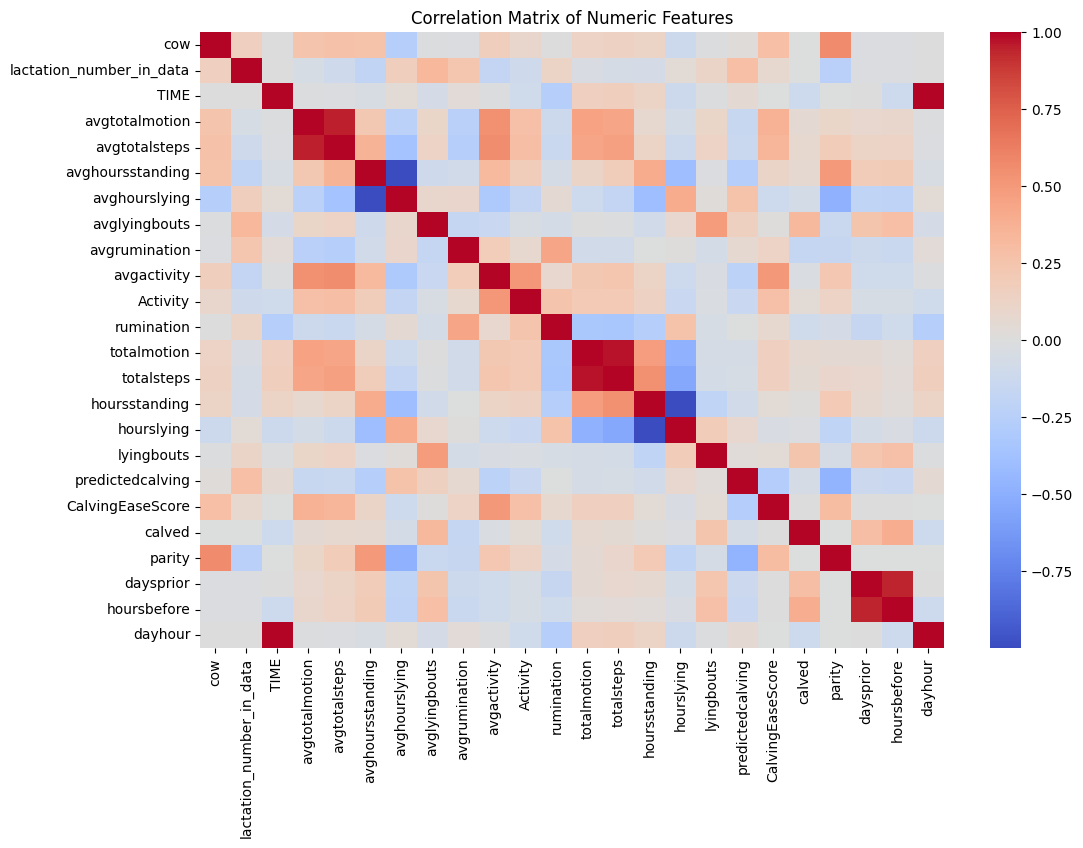

In [99]:
# Correlation Matrix Plot
plt.figure(figsize=(12, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


## Feature-wise Distribution Plots

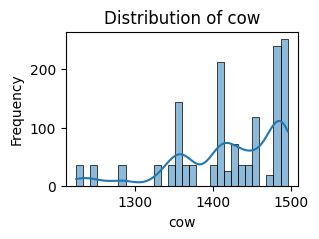

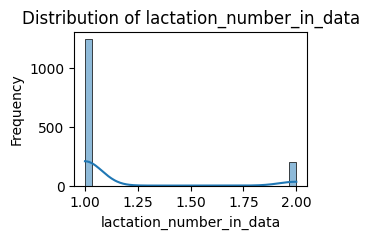

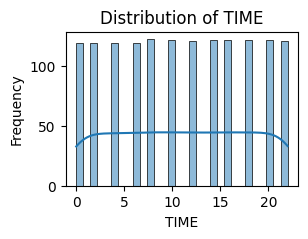

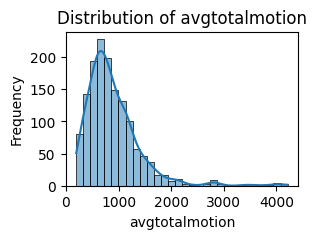

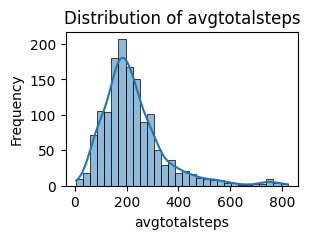

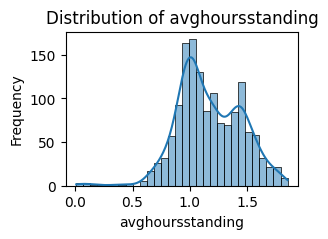

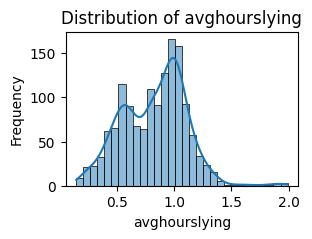

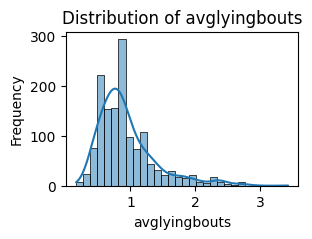

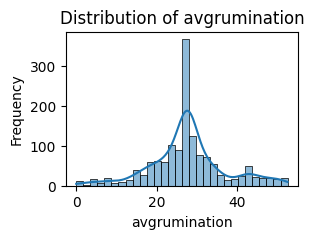

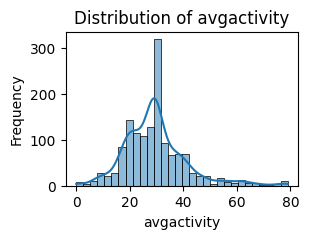

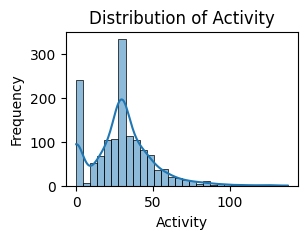

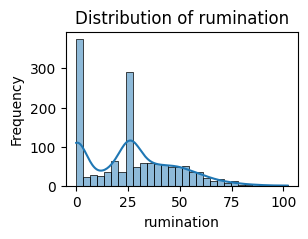

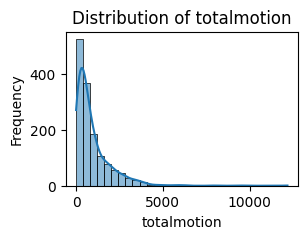

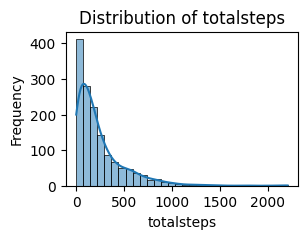

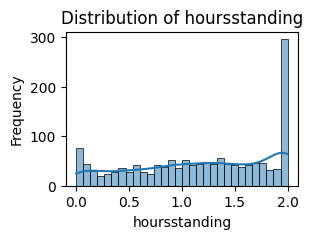

In [100]:
# Visualize distributions for selected numeric features
sample_features = numeric_cols[:15]  
for feature in sample_features:
    plt.figure(figsize=(3, 2))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


## Correlation Table (Sorted by Target)

In [101]:
# Generate correlation table with respect to the target
target = 'CalvingEaseScore'
correlations = df[numeric_cols].corr()[target].drop(target).sort_values(ascending=False)
corr_df = correlations.to_frame(name='Correlation with CalvingEaseScore')

print("\nFeatures Sorted by Correlation with CalvingEaseScore (Descending):")
print(corr_df)



Features Sorted by Correlation with CalvingEaseScore (Descending):
                          Correlation with CalvingEaseScore
avgactivity                                        0.504115
avgtotalmotion                                     0.367829
avgtotalsteps                                      0.348367
parity                                             0.301307
cow                                                0.281977
Activity                                           0.281557
totalsteps                                         0.160098
totalmotion                                        0.159791
avgrumination                                      0.129291
avghoursstanding                                   0.115568
rumination                                         0.074357
lactation_number_in_data                           0.074162
lyingbouts                                         0.046637
hoursstanding                                      0.040687
avglyingbouts                   

## Target Distribution Plot

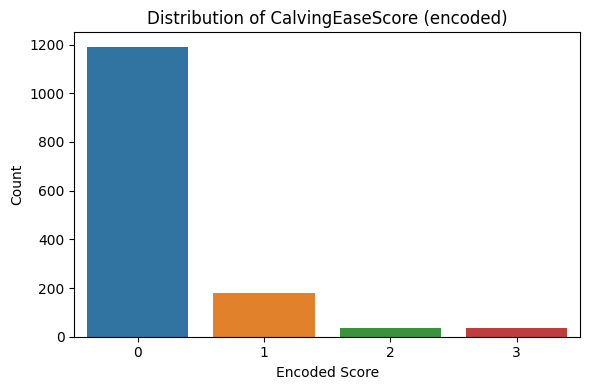

In [102]:
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
# Although the CES score in the data contains {1, 3, 4, 5}, models encodes the predictions as {0, 1, 2, 3}
plt.title('Distribution of CalvingEaseScore (encoded)')
plt.xlabel('Encoded Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## Feature Engineering

In [103]:
# Creating more meaningful features from the existing ones to improve model performance
if {'lying_time','steps'}.issubset(df.columns):
    df['lying_steps_interaction'] = df['lying_time'] * df['steps']

if {'eating_time','standing_time'}.issubset(df.columns):
    df['eat_stand_ratio'] = df['eating_time'] / (df['standing_time'] + 1e-5)

if {'rumination_time','walking_speed'}.issubset(df.columns):
    df['rum_walk_ratio'] = df['rumination_time'] / (df['walking_speed'] + 1e-5)

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()


## Train/Test Split

In [104]:
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print("Train class counts:", y_train.value_counts().to_dict())
print("Test  class counts:", y_test.value_counts().to_dict())


Train samples: 1154, Test samples: 289
Train class counts: {0: 952, 1: 144, 2: 29, 3: 29}
Test  class counts: {0: 239, 1: 36, 3: 7, 2: 7}


## Define and Evaluate Models

In [105]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, solver='saga'))
])

models = {
    'LogisticRegression': lr_pipeline,
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


LogisticRegression CV Accuracy: 0.8743 ± 0.0074
RandomForest CV Accuracy: 0.9827 ± 0.0099
XGBoost CV Accuracy: 0.9957 ± 0.0027


## Hyperparameter Tuning (XGBoost)

In [106]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01],
    'gamma': [0, 0.2],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    xgb, param_grid, cv=3, scoring='accuracy',
    n_jobs=-1, verbose=1, error_score='raise'
)
grid.fit(X_train, y_train)

print("\nBest XGBoost params:", grid.best_params_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best XGBoost params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}


## Feature Importance & Interpretation (Top 15)

- When you train an XGBoost model, it computes feature importance based on:
- *Gain*: how much each feature improves decision splits.
- *Frequency*: how often a feature is used in the trees.
- *Coverage*: how many samples a feature split applies to.


Top 15 Feature Importances from Best XGBoost Model:
                     Feature  Importance
0                        cow    0.144056
9                avgactivity    0.100306
17          predictedcalving    0.084106
1   lactation_number_in_data    0.081902
6              avghourslying    0.079806
8              avgrumination    0.069650
5           avghoursstanding    0.067148
19                    parity    0.065184
7              avglyingbouts    0.062372
4              avgtotalsteps    0.056629
3             avgtotalmotion    0.042730
10                  Activity    0.029160
20                 daysprior    0.021704
21               hoursbefore    0.019028
11                rumination    0.016359


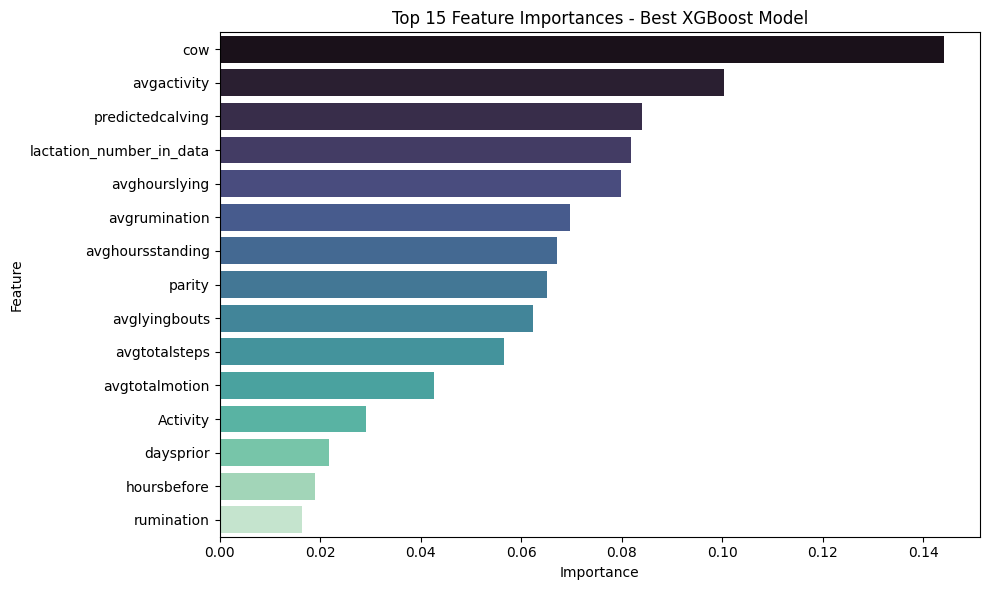

In [107]:
# Extract best model from GridSearchCV
best_xgb_model = grid.best_estimator_

# Get feature importances
importances = best_xgb_model.feature_importances_
features_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

# Print top 15 features
print("\nTop 15 Feature Importances from Best XGBoost Model:")
print(features_importance_df)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(data=features_importance_df, x='Importance', y='Feature', palette='mako')
plt.title('Top 15 Feature Importances - Best XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Final Evaluation

In [108]:
best = grid.best_estimator_
y_pred = best.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Weighted F1 Score:", f1_score(y_test, y_pred, average='weighted'))



Test Accuracy: 0.9896193771626297

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       239
           1       1.00      0.94      0.97        36
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         7

    accuracy                           0.99       289
   macro avg       1.00      0.95      0.97       289
weighted avg       0.99      0.99      0.99       289

Weighted F1 Score: 0.989419801184507


 96%|=================== | 1111/1156 [00:13<00:00]       

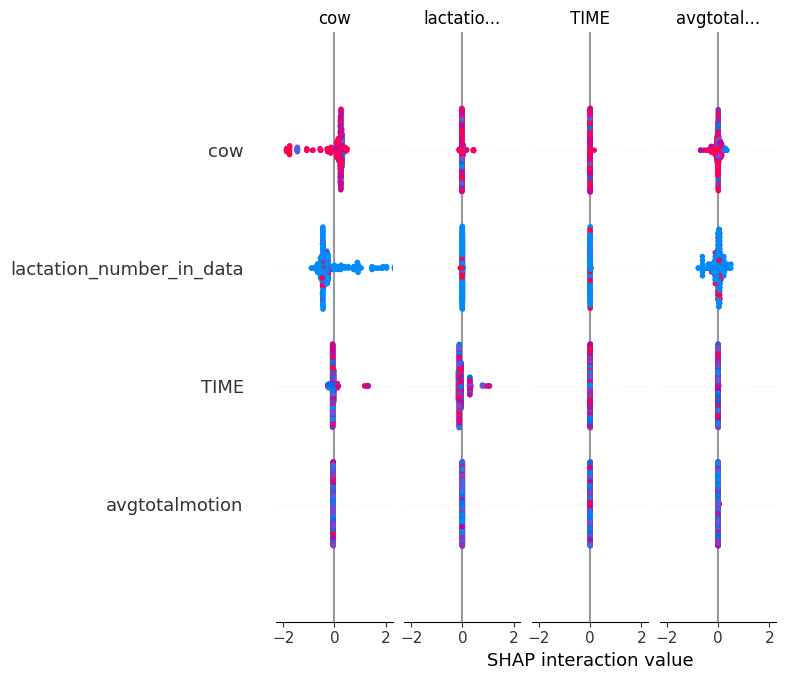

In [114]:
# ─── SHAP VALUE IMPACT ON MODEL OUTPUT ─────────────────────────────────────────

import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(best, X_train, feature_names=X.columns)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Summary plot showing distribution and impact of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
